In [19]:
from google.colab import drive
drive.mount('/gdrive')
%cd '/gdrive/MyDrive/Colab Notebooks/WRI-Hackathon/python_scripts/training/KRS'

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/MyDrive/Colab Notebooks/WRI-Hackathon/python_scripts/training/KRS


### Import libraries

In [20]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from torch.optim.lr_scheduler import OneCycleLR, ReduceLROnPlateau
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import sys
# sys.path.insert(0, '../models')
# from krs_inflow_model import SimpleMLP

### Read Datasets

In [21]:
inflow_df = pd.read_csv('../../dataset/reservoir_dataset_engg.csv')
inflow_df = inflow_df[inflow_df['RESERVOIR'] == 'K.R.S']
print(inflow_df.shape)
inflow_df.head()

(3274, 9)


,RESERVOIR,PRESENT_STORAGE_TMC,RES_LEVEL_FT,INFLOW_CUSECS,OUTFLOW_CUECS,YEAR,MONTH,DATE,DAY
0,K.R.S,46.42,122.59,2029.0,2000.0,2011,1,1,0
1,K.R.S,46.54,122.68,3084.0,1490.0,2011,1,2,1
2,K.R.S,46.64,122.75,2776.0,1491.0,2011,1,3,2
3,K.R.S,46.69,122.79,2311.0,1491.0,2011,1,4,3
4,K.R.S,46.70,122.80,1847.0,1491.0,2011,1,5,4


In [22]:
rainfall_departure_df = pd.read_csv('../../dataset/Rainfall 2010-2020/rainfall_departure_dataset.csv')
print(rainfall_departure_df.shape)
rainfall_departure_df.head()

(4004, 6)


,DISTRICTS,RAINFALL,YEAR,MONTH,DEPARTURE,SEASON
0,BAGALKOTE,0.0,2008,1,-100.0,WINTER
1,BELLARY,0.0,2008,1,-100.0,WINTER
2,KOLAR,0.0,2008,1,-100.0,WINTER
3,GULBARGA,0.0,2008,1,-100.0,WINTER
4,BANGALORE URBAN,0.1,2008,1,-88.0,WINTER


### Dataset Transformation

In [23]:
inflow_df = inflow_df.drop(columns=['RESERVOIR', 'PRESENT_STORAGE_TMC', 'RES_LEVEL_FT', 'OUTFLOW_CUECS', 'DAY'])
inflow_df.head()

,INFLOW_CUSECS,YEAR,MONTH,DATE
0,2029.0,2011,1,1
1,3084.0,2011,1,2
2,2776.0,2011,1,3
3,2311.0,2011,1,4
4,1847.0,2011,1,5


In [24]:
rainfall_departure_df = rainfall_departure_df[rainfall_departure_df['DISTRICTS'] == 'KODAGU']
rainfall_departure_df['YEAR'] = rainfall_departure_df['YEAR'].astype(float)
rainfall_departure_df['MONTH'] = rainfall_departure_df['MONTH'].astype(float)
rainfall_departure_df.shape

(156, 6)

### Dataset and DataLoader

In [25]:
month_le = LabelEncoder().fit(inflow_df['MONTH'].unique())
date_le = LabelEncoder().fit(inflow_df['DATE'].unique())
season_le = LabelEncoder().fit(rainfall_departure_df['SEASON'].unique())

In [26]:
train_inflow_df = inflow_df[inflow_df['YEAR'] < 2020]
val_inflow_df = inflow_df[inflow_df['YEAR'] == 2020]

train_inflow_df.shape, val_inflow_df.shape

((2944, 4), (330, 4))

In [27]:
class InflowDataset(Dataset):
    def __init__(self, df):
        self.df = df
    
    def __getitem__(self, index):
        inflow, year, month, date = self.df.iloc[index].values
        _, monthly_rainfall, year, month, departure, season = rainfall_departure_df[(rainfall_departure_df['YEAR'] == year) & (rainfall_departure_df['MONTH'] == month)].values[0]
        prev_rainfall_departure_df = rainfall_departure_df[(rainfall_departure_df['YEAR'] < year) & (rainfall_departure_df['MONTH'] == month)].sort_values('YEAR', ascending=False).head(3)
        prev_avg_rainfall = prev_rainfall_departure_df['RAINFALL'].values.mean()
        prev_avg_departure = prev_rainfall_departure_df['DEPARTURE'].values.mean()
        
        month_transformed = month_le.transform([month])
        date_transformed = date_le.transform([date])
        season_transformed = season_le.transform([season])

        return (torch.tensor(month_transformed[0]), \
                torch.tensor(date_transformed[0]), \
                torch.tensor(season_transformed[0]), \
                torch.FloatTensor([prev_avg_rainfall, prev_avg_departure])), (torch.FloatTensor([inflow]), torch.FloatTensor([monthly_rainfall]))
    
    def __len__(self):
        return self.df.shape[0]

In [28]:
train_ds = InflowDataset(train_inflow_df)
val_ds = InflowDataset(val_inflow_df)
train_dl = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=8)
val_dl = DataLoader(val_ds, batch_size=32, num_workers=8)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


### Model

In [29]:
# class SimpleMLP(nn.Module):
#     def __init__(self, nmonth, ndate, nseason):
#         super().__init__()
#         self.month_emb = nn.Embedding(num_embeddings=nmonth, embedding_dim=128)
#         self.date_emb = nn.Embedding(num_embeddings=ndate, embedding_dim=128)
#         self.season_emb = nn.Embedding(num_embeddings=nseason, embedding_dim=128)
#         self.prev_data_layer = nn.Sequential(
#             nn.Linear(in_features=2, out_features=64),
#             nn.LeakyReLU(),
#             nn.Linear(in_features=64, out_features=128),
#             nn.LeakyReLU()
#         )
#         self.hidden_layer_1 = nn.Sequential(
#             nn.Linear(in_features=128*4, out_features=1024),
#             nn.LeakyReLU(),
#             nn.Dropout(0.4),
#             nn.Linear(in_features=1024, out_features=1024),
#             nn.LeakyReLU(),
#             nn.Linear(in_features=1024, out_features=512),
#             nn.LeakyReLU(),
#             nn.Linear(in_features=512, out_features=256),
#             nn.LeakyReLU(),
#         )
#         self.rainfall_layer = nn.Sequential(
#             nn.Linear(in_features=256, out_features=256),
#             nn.LeakyReLU(),
#             nn.BatchNorm1d(num_features=256),
#             nn.Linear(in_features=256, out_features=64),
#             nn.LeakyReLU(),
#             nn.Linear(in_features=64, out_features=1),
#             nn.ReLU()
#         )
        
#         self.inflow_layer = nn.Sequential(
#             nn.Linear(in_features=256, out_features=256),
#             nn.LeakyReLU(),
#             nn.BatchNorm1d(num_features=256),
#             nn.Linear(in_features=256, out_features=64),
#             nn.LeakyReLU(),
#             nn.Linear(in_features=64, out_features=1),
#             nn.ReLU()
#         )
    
#     def forward(self, x_month, x_date, x_season, x_prev_data):
#         month_out = self.month_emb(x_month)
#         date_out = self.date_emb(x_date)
#         season_out = self.season_emb(x_season)
#         prev_data_out = self.prev_data_layer(x_prev_data)

#         x = torch.cat([month_out, date_out, season_out, prev_data_out], axis=1)
#         hidden_out = self.hidden_layer(x)
#         rainfall_out = self.rainfall_layer(hidden_out)
#         inflow_out = self.inflow_layer(hidden_out)

#         return rainfall_out, inflow_out
    
#     def weight_init(self):
#         for m in self.modules():
#             if isinstance(m, nn.Linear):
#                 nn.init.normal_(m.weight)
#                 nn.init.zeros_(m.bias)
#             elif isinstance(m, nn.Embedding):
#                 nn.init.normal_(m.weight)

In [30]:
# class SimpleMLP(nn.Module):
#     def __init__(self, nmonth, ndate, nseason):
#         super().__init__()
#         self.month_emb = nn.Embedding(num_embeddings=nmonth, embedding_dim=128)
#         self.date_emb = nn.Embedding(num_embeddings=ndate, embedding_dim=128)
#         self.season_emb = nn.Embedding(num_embeddings=nseason, embedding_dim=128)
#         self.prev_data_layer = nn.Sequential(
#             nn.Linear(in_features=2, out_features=64),
#             nn.LeakyReLU(),
#             nn.Linear(in_features=64, out_features=128),
#             nn.LeakyReLU()
#         )
#         self.res_layer_1 = nn.Sequential(
#             nn.BatchNorm1d(num_features=128*4),
#             nn.ReLU(),
#             nn.Linear(in_features=128*4, out_features=128*4),
#             nn.BatchNorm1d(num_features=128*4),
#             nn.ReLU(),
#             nn.Linear(in_features=128*4, out_features=128*4),
#         )
#         self.hidden_layer_1 = nn.Sequential(
#             nn.Linear(in_features=128*4, out_features=128*2),
#             nn.ReLU()
#         )
#         self.res_layer_2 = nn.Sequential(
#             nn.BatchNorm1d(num_features=128*2),
#             nn.ReLU(),
#             nn.Linear(in_features=128*2, out_features=128*2),
#             nn.BatchNorm1d(num_features=128*2),
#             nn.ReLU(),
#             nn.Linear(in_features=128*2, out_features=128*2),
#         )
#         self.hidden_layer_2 = nn.Sequential(
#             nn.Linear(in_features=128*2, out_features=128),
#             nn.ReLU()
#         )
#         self.rainfall_layer = nn.Sequential(
#             nn.Linear(in_features=128, out_features=128),
#             nn.LeakyReLU(),
#             nn.BatchNorm1d(num_features=128),
#             nn.Linear(in_features=128, out_features=32),
#             nn.LeakyReLU(),
#             nn.Linear(in_features=32, out_features=1),
#             nn.ReLU()
#         )
        
#         self.inflow_layer = nn.Sequential(
#             nn.Linear(in_features=128, out_features=128),
#             nn.LeakyReLU(),
#             nn.BatchNorm1d(num_features=128),
#             nn.Linear(in_features=128, out_features=64),
#             nn.LeakyReLU(),
#             nn.Linear(in_features=64, out_features=1),
#             nn.ReLU()
#         )
    
#     def forward(self, x_month, x_date, x_season, x_prev_data):
#         month_out = self.month_emb(x_month)
#         date_out = self.date_emb(x_date)
#         season_out = self.season_emb(x_season)
#         prev_data_out = self.prev_data_layer(x_prev_data)

#         x = torch.cat([month_out, date_out, season_out, prev_data_out], axis=1)
#         res_out_1 = self.res_layer_1(x)
#         hidden_out_1 = self.hidden_layer_1(res_out_1 + x)
#         res_out_2 = self.res_layer_2(hidden_out_1)
#         hidden_out_2 = self.hidden_layer_2(res_out_2 + hidden_out_1)
        
#         rainfall_out = self.rainfall_layer(hidden_out_2)
#         inflow_out = self.inflow_layer(hidden_out_2)

#         return rainfall_out, inflow_out
    
#     def weight_init(self):
#         for m in self.modules():
#             if isinstance(m, nn.Linear):
#                 nn.init.normal_(m.weight)
#                 nn.init.zeros_(m.bias)
#             elif isinstance(m, nn.Embedding):
#                 nn.init.normal_(m.weight)

In [53]:
class SimpleMLP(nn.Module):
    def __init__(self, nmonth, ndate, nseason, cardinality=3):
        super().__init__()
        self.month_emb = nn.Embedding(num_embeddings=nmonth, embedding_dim=128)
        self.date_emb = nn.Embedding(num_embeddings=ndate, embedding_dim=128)
        self.season_emb = nn.Embedding(num_embeddings=nseason, embedding_dim=128)
        self.prev_data_layer = nn.Sequential(
            nn.Linear(in_features=2, out_features=64),
            nn.LeakyReLU(),
            nn.Linear(in_features=64, out_features=128),
            nn.LeakyReLU()
        )
        self.res_layer_1 = nn.ModuleList([nn.Sequential(
            nn.BatchNorm1d(num_features=128*4),
            nn.ReLU(),
            nn.Linear(in_features=128*4, out_features=128*4),
            nn.BatchNorm1d(num_features=128*4),
            nn.ReLU(),
            nn.Linear(in_features=128*4, out_features=128*4),
        ) for i in range(cardinality)])
        self.hidden_layer_1 = nn.Sequential(
            nn.Linear(in_features=128*4, out_features=128*2),
            nn.ReLU()
        )
        self.res_layer_2 = nn.ModuleList([nn.Sequential(
            nn.BatchNorm1d(num_features=128*2),
            nn.ReLU(),
            nn.Linear(in_features=128*2, out_features=128*2),
            nn.BatchNorm1d(num_features=128*2),
            nn.ReLU(),
            nn.Linear(in_features=128*2, out_features=128*2),
        ) for i in range(cardinality)])
        self.hidden_layer_2 = nn.Sequential(
            nn.Linear(in_features=128*2, out_features=128),
            nn.ReLU()
        )
        self.rainfall_layer = nn.Sequential(
            nn.Linear(in_features=128, out_features=128),
            nn.LeakyReLU(),
            nn.BatchNorm1d(num_features=128),
            nn.Linear(in_features=128, out_features=32),
            nn.LeakyReLU(),
            nn.Linear(in_features=32, out_features=1),
            nn.ReLU()
        )
        
        self.inflow_layer = nn.Sequential(
            nn.Linear(in_features=128, out_features=128),
            nn.LeakyReLU(),
            nn.BatchNorm1d(num_features=128),
            nn.Linear(in_features=128, out_features=64),
            nn.LeakyReLU(),
            nn.Linear(in_features=64, out_features=1),
            nn.ReLU()
        )
    
    def forward(self, x_month, x_date, x_season, x_prev_data):
        month_out = self.month_emb(x_month)
        date_out = self.date_emb(x_date)
        season_out = self.season_emb(x_season)
        prev_data_out = self.prev_data_layer(x_prev_data)

        x = torch.cat([month_out, date_out, season_out, prev_data_out], axis=1)
        res_out_1 = sum([layer(x) for layer in self.res_layer_1])
        hidden_out_1 = self.hidden_layer_1(res_out_1 + x)
        res_out_2 = sum([layer(hidden_out_1) for layer in self.res_layer_2])
        hidden_out_2 = self.hidden_layer_2(res_out_2 + hidden_out_1)
        
        rainfall_out = self.rainfall_layer(hidden_out_2)
        inflow_out = self.inflow_layer(hidden_out_2)

        return 0, inflow_out
    
    def weight_init(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight)
                nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Embedding):
                nn.init.normal_(m.weight)

### Training

In [57]:
def train(model, epochs, lr):
    opt = Adam(model.parameters(), lr=lr)
    scheduler = ReduceLROnPlateau(opt, patience=10, min_lr=1e-8)
    criterion = nn.MSELoss()

    mean_inflow = train_inflow_df['INFLOW_CUSECS'].mean()
    mean_rainfall = rainfall_departure_df['RAINFALL'].mean()
    inflow_loss_weight = int((mean_inflow + mean_rainfall) / mean_inflow)
    rainfall_loss_weight = int((mean_inflow + mean_rainfall) / mean_rainfall)
    for epoch in range(epochs):
        train_loss = 0
        val_loss = 0

        model.train()
        for xb, yb in train_dl:
            x_month = xb[0].cuda()
            x_date = xb[1].cuda()
            x_season = xb[2].cuda()
            x_prev_data = xb[3].cuda()
            y_inflow = yb[0].cuda()
            y_rainfall = yb[1].cuda()

            y_hat = model(x_month, x_date, x_season, x_prev_data)
            y_hat_rainfall = y_hat[0]
            y_hat_inflow = y_hat[1]
            loss = rainfall_loss_weight * criterion(y_hat_rainfall, y_rainfall) + inflow_loss_weight * criterion(y_hat_inflow, y_inflow)

            opt.zero_grad()
            loss.backward()
            opt.step()

            train_loss += loss.item()
        
        model.eval()
        with torch.no_grad():
            for xb, yb in val_dl:
                x_month = xb[0].cuda()
                x_date = xb[1].cuda()
                x_season = xb[2].cuda()
                x_prev_data = xb[3].cuda()
                y_inflow = yb[0].cuda()
                y_rainfall = yb[1].cuda()

                y_hat = model(x_month, x_date, x_season, x_prev_data)
                y_hat_rainfall = y_hat[0]
                y_hat_inflow = y_hat[1]
                loss = rainfall_loss_weight * criterion(y_hat_rainfall, y_rainfall) + inflow_loss_weight * criterion(y_hat_inflow, y_inflow)

                val_loss += loss.item()
                
        scheduler.step(train_loss)

        if scheduler._last_lr[0] <= 1e-06:
            break
        print(f'Epoch - {epoch+1} | LR - {scheduler._last_lr[0]} | Train Loss - {round(train_loss / len(train_dl), 2)} | Val Loss - {round(val_loss / len(val_dl), 2)}')

In [58]:
model = SimpleMLP(len(month_le.classes_), len(date_le.classes_), len(season_le.classes_)).cuda()
model.weight_init()

In [59]:
train(model, epochs=5, lr=1e-02)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch - 1 | LR - 0.01 | Train Loss - 43563431.24 | Val Loss - 17005819.55
Epoch - 2 | LR - 0.01 | Train Loss - 30211094.27 | Val Loss - 14595233.66
Epoch - 3 | LR - 0.01 | Train Loss - 29241401.6 | Val Loss - 15914765.47
Epoch - 4 | LR - 0.01 | Train Loss - 29053220.28 | Val Loss - 14819763.52
Epoch - 5 | LR - 0.01 | Train Loss - 27500929.9 | Val Loss - 16655517.62


In [60]:
train(model, epochs=100, lr=1e-03)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch - 1 | LR - 0.001 | Train Loss - 26382319.89 | Val Loss - 15260612.5
Epoch - 2 | LR - 0.001 | Train Loss - 25930018.64 | Val Loss - 15393964.65
Epoch - 3 | LR - 0.001 | Train Loss - 25149085.71 | Val Loss - 14855598.78
Epoch - 4 | LR - 0.001 | Train Loss - 24572053.39 | Val Loss - 15485321.7
Epoch - 5 | LR - 0.001 | Train Loss - 24848551.75 | Val Loss - 16289788.41
Epoch - 6 | LR - 0.001 | Train Loss - 24452639.76 | Val Loss - 15804187.55
Epoch - 7 | LR - 0.001 | Train Loss - 24349328.86 | Val Loss - 15814960.11
Epoch - 8 | LR - 0.001 | Train Loss - 24392687.69 | Val Loss - 16589211.07
Epoch - 9 | LR - 0.001 | Train Loss - 24719091.42 | Val Loss - 15482655.74
Epoch - 10 | LR - 0.001 | Train Loss - 24372628.66 | Val Loss - 15720483.55
Epoch - 11 | LR - 0.001 | Train Loss - 24605467.0 | Val Loss - 15481408.77
Epoch - 12 | LR - 0.001 | Train Loss - 23027054.04 | Val Loss - 460333717008.94
Epoch - 13 | LR - 0.001 | Train Loss - 23984571.86 | Val Loss - 15448879.1
Epoch - 14 | LR - 0.0

In [61]:
model

SimpleMLP(
  (month_emb): Embedding(12, 128)
  (date_emb): Embedding(31, 128)
  (season_emb): Embedding(3, 128)
  (prev_data_layer): Sequential(
    (0): Linear(in_features=2, out_features=64, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=64, out_features=128, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
  )
  (res_layer_1): ModuleList(
    (0): Sequential(
      (0): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): ReLU()
      (2): Linear(in_features=512, out_features=512, bias=True)
      (3): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (4): ReLU()
      (5): Linear(in_features=512, out_features=512, bias=True)
    )
    (1): Sequential(
      (0): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): ReLU()
      (2): Linear(in_features=512, out_features=512, bias=True)
      (3): BatchNorm1d(512, eps=1e-05, momentum=0.1,

### Prediction on Validation Dataset

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


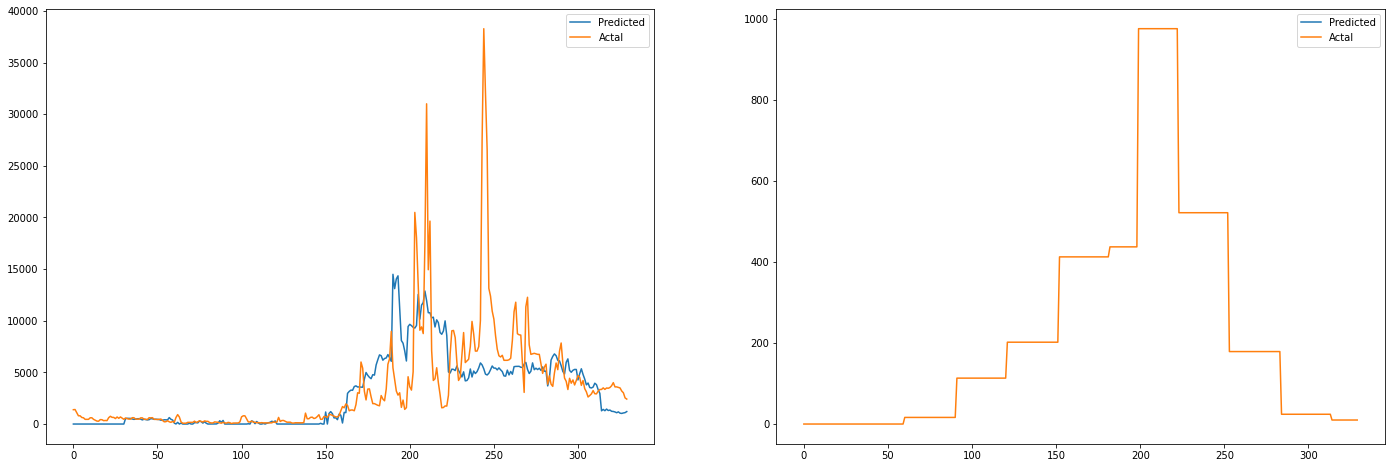

In [63]:
y_actual_rainfall, y_pred_rainfall = [], []
y_actual_inflow, y_pred_inflow = [], []
model.eval()
with torch.no_grad():
    for xb, yb in val_dl:
        x_month = xb[0].cuda()
        x_date = xb[1].cuda()
        x_season = xb[2].cuda()
        x_prev_data = xb[3].cuda()
        y_inflow = yb[0]
        y_rainfall = yb[1]

        y_hat = model(x_month, x_date, x_season, x_prev_data)
        y_hat_rainfall = y_hat[0]
        y_hat_inflow = y_hat[1]

        y_actual_rainfall += y_rainfall.data.tolist()
        y_actual_inflow += y_inflow.data.tolist()
        y_pred_rainfall += y_hat_rainfall.cpu().data.tolist()
        y_pred_inflow += y_hat_inflow.cpu().data.tolist()

y_actual_rainfall = np.array(y_actual_rainfall).flatten()
y_actual_inflow = np.array(y_actual_inflow).flatten()
y_pred_rainfall = np.array(y_pred_rainfall).flatten()
y_pred_inflow = np.array(y_pred_inflow).flatten()

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24,8))
ax1.plot(y_pred_inflow, label='Predicted')
ax1.plot(y_actual_inflow, label='Actal')
ax1.legend()
ax2.plot(y_pred_rainfall, label='Predicted')
ax2.plot(y_actual_rainfall, label='Actal')
ax2.legend()
plt.show()

### Prediction on entire Dataset

In [64]:
def pred(df):
    pred_ds = InflowDataset(df.copy())
    pred_dl = DataLoader(pred_ds, batch_size=len(pred_ds))

    model.eval()
    with torch.no_grad():
        for x, y in pred_dl:
            x_month = x[0].cuda()
            x_date = x[1].cuda()
            x_season = x[2].cuda()
            x_prev_data = x[3].cuda()
            y_inflow = yb[0]
            y_rainfall = yb[1]

            y_hat = model(x_month, x_date, x_season, x_prev_data)
            y_hat_rainfall = y_hat[0]
            y_hat_inflow = y_hat[1]

    return y_hat_inflow.data.cpu().view(-1).tolist(), y_hat_rainfall.data.cpu().view(-1).tolist()

In [65]:
model_test_df = inflow_df.sort_values(by=['YEAR', 'DATE']).copy()
model_test_df['Predicted_Inflow'], model_test_df['Predicted_Rainfall'] = pred(model_test_df)
model_test_df[:10]

AttributeError: ignored

In [ ]:
avg_daily_pred_inflow = model_test_df.groupby(['MONTH', 'DATE'])['Predicted_Inflow'].mean().values
avg_daily_actual_inflow = model_test_df.groupby(['MONTH', 'DATE'])['INFLOW_CUSECS'].mean().values
avg_daily_pred_rainfall = model_test_df.groupby(['MONTH'])['Predicted_Rainfall'].mean().values
avg_daily_actual_rainfall = rainfall_departure_df.groupby(['MONTH'])['RAINFALL'].mean().values

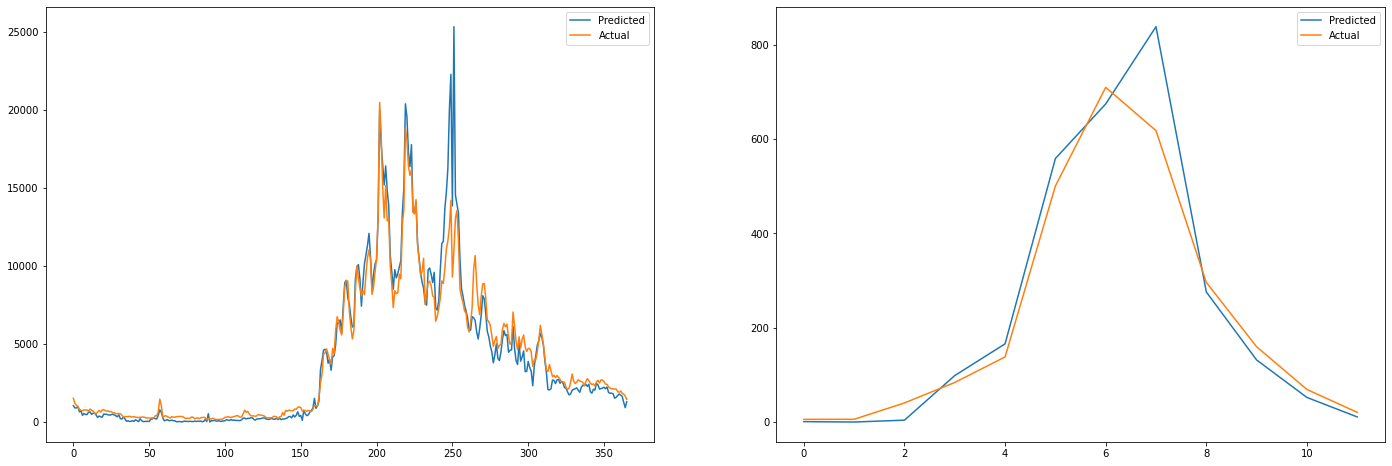

In [40]:
# plt.figure()
f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(24, 8))
ax1.plot(avg_daily_pred_inflow, label='Predicted')
ax1.plot(avg_daily_actual_inflow, label='Actual')
ax1.legend()
ax2.plot(avg_daily_pred_rainfall, label='Predicted')
ax2.plot(avg_daily_actual_rainfall, label='Actual')
ax2.legend()
plt.show()

In [41]:
model_test_df['Predicted_Rainfall'].describe()

count    3274.000000
mean      242.250775
std       359.179465
min         0.000000
25%         3.425028
50%       107.914425
75%       410.663292
max      2997.997559
Name: Predicted_Rainfall, dtype: float64

In [42]:
rainfall_departure_df['RAINFALL'].describe()

count     156.000000
mean      220.685897
std       287.744814
min         0.000000
25%        13.800000
50%       103.800000
75%       314.500000
max      1318.100000
Name: RAINFALL, dtype: float64

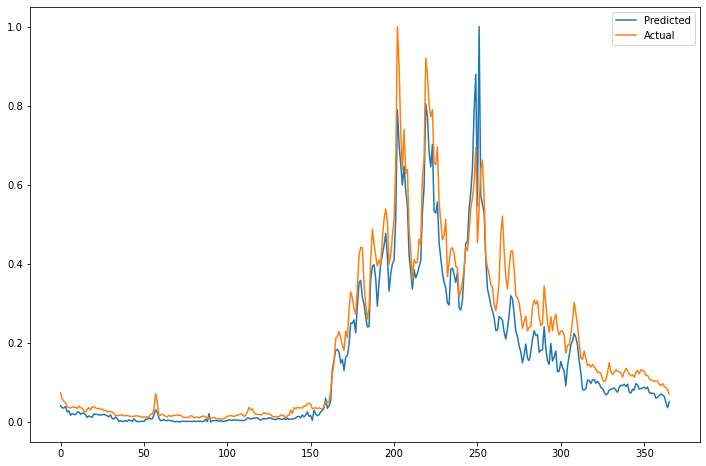

In [43]:
plt.figure(figsize=(12, 8))
plt.plot(avg_daily_pred_inflow / avg_daily_pred_inflow.max(), label='Predicted')
plt.plot(avg_daily_actual_inflow / avg_daily_actual_inflow.max(), label='Actual')

plt.legend()
plt.show()

In [44]:
model_test_df.sort_values(by=['YEAR', 'MONTH', 'DATE'], inplace=True)

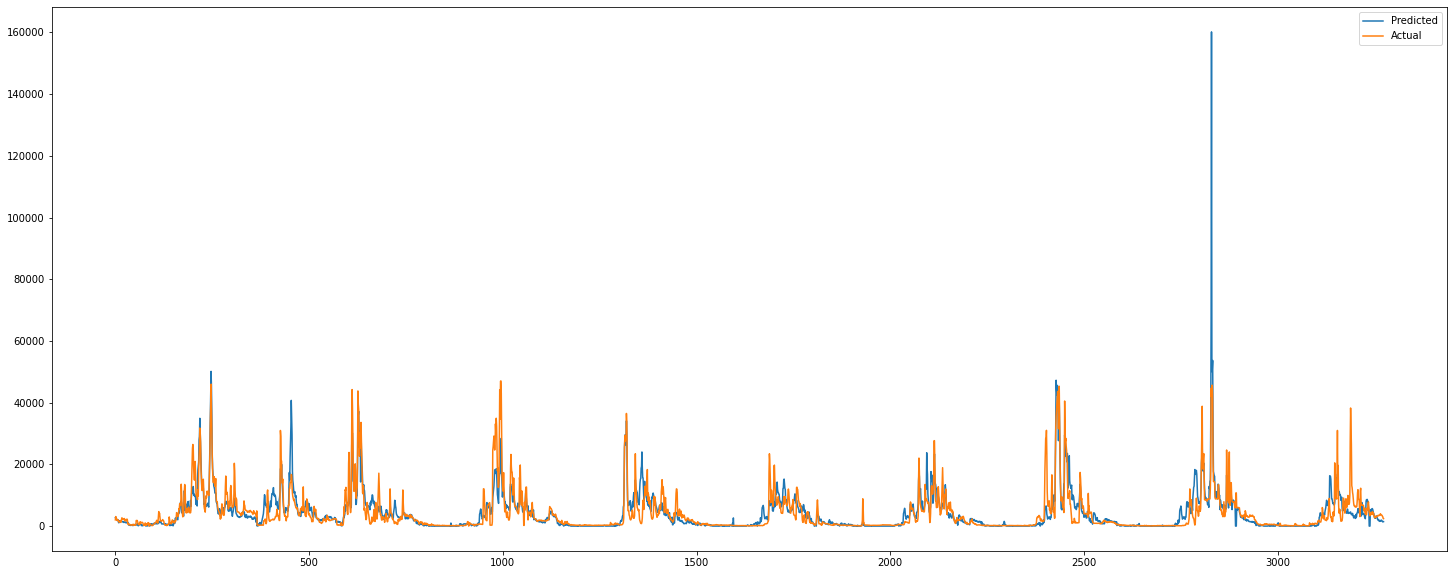

In [45]:
plt.figure(figsize=(25, 10))
plt.plot(model_test_df['Predicted_Inflow'], label='Predicted')
plt.plot(model_test_df['INFLOW_CUSECS'], label='Actual')
plt.legend()
plt.show()

In [46]:
pred_rainfall_df = model_test_df[['YEAR', 'MONTH', 'Predicted_Rainfall']].groupby(['YEAR', 'MONTH']).mean().reset_index()
rainfall_with_pred_df = rainfall_departure_df.merge(pred_rainfall_df, on=['YEAR', 'MONTH'])
rainfall_with_pred_df = rainfall_with_pred_df.sort_values(by=['YEAR', 'MONTH']).reset_index()
rainfall_with_pred_df

,index,DISTRICTS,RAINFALL,YEAR,MONTH,DEPARTURE,SEASON,Predicted_Rainfall
0,0,KODAGU,0.7,2011.0,1.0,-80.0,WINTER,0.008818
1,10,KODAGU,22.2,2011.0,2.0,429.0,WINTER,0.451043
2,19,KODAGU,13.2,2011.0,3.0,-29.0,SUMMER,1.512449
3,27,KODAGU,138.5,2011.0,4.0,54.0,SUMMER,110.099190
4,35,KODAGU,107.5,2011.0,5.0,-30.0,SUMMER,165.141181
...,...,...,...,...,...,...,...,...
109,73,KODAGU,974.9,2020.0,8.0,66.0,MONSOON,2768.275228
110,83,KODAGU,521.1,2020.0,9.0,126.0,MONSOON,265.126904
111,93,KODAGU,178.7,2020.0,10.0,-14.0,WINTER,148.995634
112,103,KODAGU,24.1,2020.0,11.0,-69.0,WINTER,65.794502


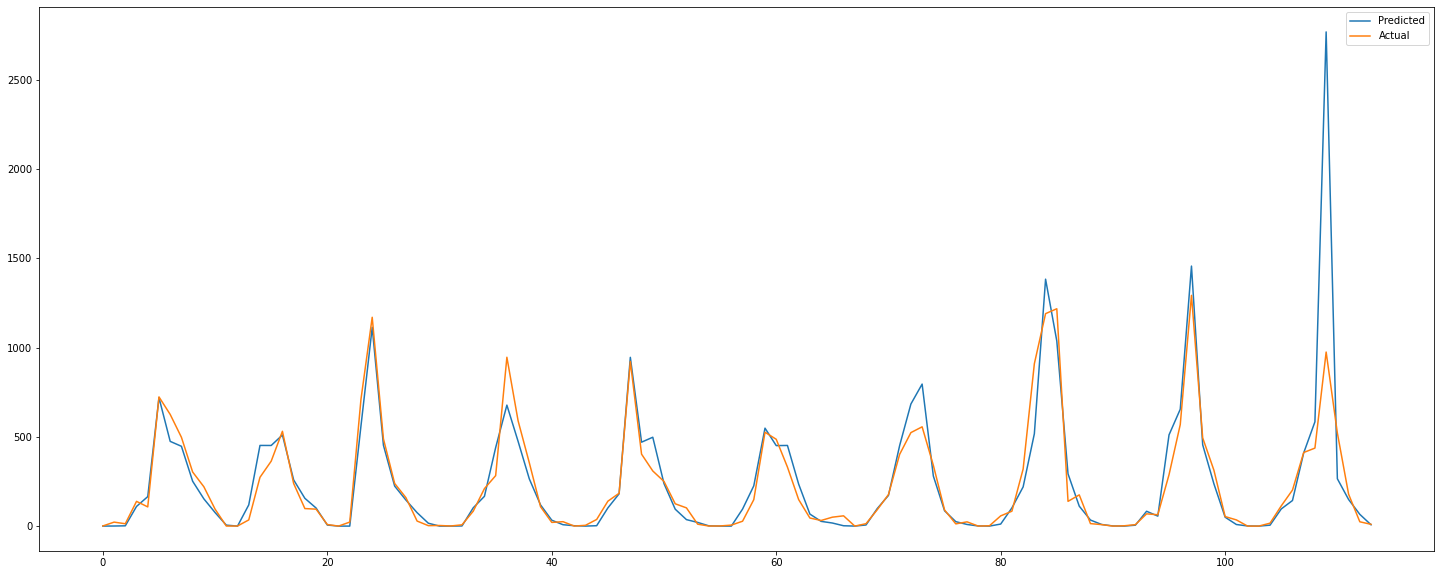

In [47]:
plt.figure(figsize=(25, 10))
plt.plot(rainfall_with_pred_df['Predicted_Rainfall'], label='Predicted')
plt.plot(rainfall_with_pred_df['RAINFALL'], label='Actual')
plt.legend()
plt.show()

In [48]:
train_data_with_pred = model_test_df[model_test_df['YEAR'] < 2020]
val_data_with_pred = model_test_df[model_test_df['YEAR'] == 2020]
train_data_with_pred.shape, val_data_with_pred.shape

((2944, 6), (330, 6))

In [49]:
train_rainfall_with_pred = rainfall_with_pred_df[rainfall_with_pred_df['YEAR'] < 2020]
val_rainfall_with_pred = rainfall_with_pred_df[rainfall_with_pred_df['YEAR'] == 2020]
train_rainfall_with_pred.shape, val_rainfall_with_pred.shape

((102, 8), (12, 8))

In [50]:
((train_data_with_pred['INFLOW_CUSECS'] - train_data_with_pred['Predicted_Inflow']) ** 2).mean() ** .5 + ((train_rainfall_with_pred['RAINFALL'] - train_rainfall_with_pred['Predicted_Rainfall']) ** 2).mean() ** .5      

4169.054300605658

In [51]:
((val_data_with_pred['INFLOW_CUSECS'] - val_data_with_pred['Predicted_Inflow']) ** 2).mean() ** .5 + ((val_rainfall_with_pred['RAINFALL'] - val_rainfall_with_pred['Predicted_Rainfall']) ** 2).mean() ** .5      

4877.434696430529

In [ ]:
# torch.save(model.state_dict(), 'inflow_rainfall_multihead_model.pth')